In [1]:
# Import libaries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import requests

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text
from textblob import TextBlob, Word
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from bs4 import BeautifulSoup
import re
import nltk
from nltk.corpus import stopwords
import datetime as dt
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

/Users/mauriekathan/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
np.random.seed(42)

# Data Retrieval

In [3]:
url = 'https://api.pushshift.io/reddit/search/submission/?subreddit=space&size=500&after=30d'

In [4]:
#inspired in combination by Brian Collins and Erik Green.

def query_pushshift(subreddit, kind='submission', skip=30, times=6, start = 0,pseudoverbose=5, size = 500,
                    subfield = ['title', 'selftext','subreddit', 'created_utc', 'author', 'num_comments', 'score', 'is_self'],
                    comfields = ['body', 'score', 'created_utc']):

#subreddit= name of the subreddit, 
#kind= part of the api to pull from. {submission,comment}, Submission being the default.
#skip=number of days to skip after each scrape,
#times= how many scapes to do at once. default = 6
#size = how many posts to scrape during each scape iteration.
#start= how many days back to start from.  I used this to make sure I was getting the same posts each time.
#pseudoverbose= prints updates after i cycles.  Default 5. (the updates are number of cycles)
#subfield = all of the specific fields from each post from the submissions api we will be scraping and saving.  
#other subfields can be found by visiting a subreddit on reddit.com, adding .json to the end of the url, and looking 
#through the 'data' dictionary keys
#comfields = same as subfields, but for comments, should you choose to set the param kind='comment'
    
    stem = f"https://api.pushshift.io/reddit/search/{kind}/?subreddit={subreddit}&size={size}"
#stem is the base url we are scraping (or in this case api). We are using the f format to fill 
#in the parameters indicated. This is scraping from a datadase of reddit posts provided by pushshift.io.
#Pushshift ingests data from various social media companies such as Twitter and Reddit 
#and makes that data available for researchers and academic institutions. 
#You can donate to pushshift at: https://pushshift.io/donations/
    posts = []
#this will be the based list we will use to pull all posts     
    
    
    count = 0
    for num in range(1, times):
        #this sets up a loop that will run as many times as we set with times peramieter
        count += 1
        URL = "{}&after={}d".format(stem, skip * num + start)
        #creates a slug to go after stem. The slug is set up to pull from numbers of days that is the skip perameter
        # times the num of the loop added to the start perameter.
        response = requests.get(URL)
        assert response.status_code == 200
        #this confirms that the status code for the api is okay
        mine = response.json()['data']
        #saves the data from the json. 'data' is the field in the reddit json where all the data we are interested is
        df = pd.DataFrame.from_dict(mine)
        #makes the dictionary we grabbed from json into a dataframe.
        posts.append(df)
        #adds the indiviual post data frame to the posts list.
        time.sleep(.25)
        #amount of time we pause between loops. it is very short since apis dont really need a sleep.
        if count%pseudoverbose == 0:                         
            print(count, 'cycles complete.')                 
 #This prints how many times we've cycled through. this is cleaner than printing each url
    
    allposts = pd.concat(posts, sort=False)
#this creates a datafram of all the posts.
    
    if kind == "submission":
        
        allposts = allposts[subfield]
#if the kind is submission grab the subfields that are specified. the defaults will pull if nothing is specified        
        allposts = allposts.drop_duplicates()
#checks for duplicates and removes them         
        allposts = allposts.loc[allposts['is_self'] == True]
#this dumps the posts that are empty
    elif kind == 'comment':                                  
   
        allposts = allposts[comfields]                               
#if the kind is comment grab the subfields that are specified. the defaults will pull if nothing is specified 
        allposts = allposts.drop_duplicates()     
#checks for duplicates and removes them      
    def get_date(created):
        return dt.date.fromtimestamp(created)
    
    _timestamp = allposts["created_utc"].apply(get_date)
    
    allposts['timestamp'] = _timestamp

    print(allposts.shape)
    
    return allposts 



In [5]:
#pull from the 'cooking' submissions subreddit 20 times starting 10 days ago
cooking_submissions = query_pushshift('Cooking',times=50,start=10)

5 cycles complete.
10 cycles complete.
15 cycles complete.
20 cycles complete.
25 cycles complete.
30 cycles complete.
35 cycles complete.
40 cycles complete.
45 cycles complete.
(24461, 9)


In [6]:
#pull from the 'cooking' submissions subreddit 20 times starting 10 days ago
cooking_comments = query_pushshift('Cooking',kind='comment',times=50,start=10)

5 cycles complete.
10 cycles complete.
15 cycles complete.
20 cycles complete.
25 cycles complete.
30 cycles complete.
35 cycles complete.
40 cycles complete.
45 cycles complete.
(24484, 4)


In [7]:
cooking_comments.head()

body  score  created_utc  \
0  I need a fucking glass, spoon, or knife.   \n\...      1   1542827402   
1  Thanks for this idea! I just found a tapas rec...      1   1542827420   
2  I can see that sort of volume requiring a mand...      1   1542827435   
3                                         Thanks! :D      1   1542827442   
4  I really like this idea! Do you use fresh or c...      1   1542827464   

    timestamp  
0  2018-11-21  
1  2018-11-21  
2  2018-11-21  
3  2018-11-21  
4  2018-11-21

In [8]:
cooking_submissions.head()

title  \
0  What bread doughs can I prep before I go to sl...   
1    What can I do with fudge that didn't set right?   
2   Extra steps in recipes that don't seem worth it?   
3  Seeking some guidance/ideas on how to deal wit...   
4     What are the best things to do with sous vide?   

                                            selftext subreddit  created_utc  \
0                                                      Cooking   1542827760   
1  My wife really wanted to make fudge this holid...   Cooking   1542827819   
2  I was browsing serious eats and was looking at...   Cooking   1542828240   
3                                          [removed]   Cooking   1542828862   
4  I’m getting a sous vide today and going to Cos...   Cooking   1542829097   

            author  num_comments  score  is_self   timestamp  
0  Crooked_Cricket            21      1     True  2018-11-21  
1         Golossos             2      1     True  2018-11-21  
2       mtbguy1981             9      1     True  2018-11-21  
3         shleem13             0      1     True  2018-11-21  
4           Cazken            11      1     True  2018-11-21

In [9]:
#saving to csv
cooking_comments.to_csv('./Data/cooking_comments_final.csv')
cooking_submissions.to_csv('./Data/cooking_submissions_final.csv')

In [10]:
#pull from the 'baking' submissions subreddit 100 times starting 10 days ago
#we are sampling more baking submissions than cooking because we are undersampling cooking because when 
#we run this code with cooking we get way more posts
baking_submissions = query_pushshift('baking',times=100,start=10)

5 cycles complete.
10 cycles complete.
15 cycles complete.
20 cycles complete.
25 cycles complete.
30 cycles complete.
35 cycles complete.
40 cycles complete.
45 cycles complete.
50 cycles complete.
55 cycles complete.
60 cycles complete.
65 cycles complete.
70 cycles complete.
75 cycles complete.
80 cycles complete.
85 cycles complete.
90 cycles complete.
95 cycles complete.
(9756, 9)


In [11]:
#what pull the comment for baking subreddit. What I discovered in playing around with sampling. There were more comments
#then there were submissions for baking so I should pull less to get a balance sample
baking_comments = query_pushshift('baking',kind='comment',times=20,start=10)

5 cycles complete.
10 cycles complete.
15 cycles complete.
(9499, 4)


In [12]:
baking_submissions.head()

title  \
0   My breads aren't rising, what could I be doing...   
1   Forgot sugar in pumpkin pie...how can I turn i...   
3                        HELP may have used bad eggs!   
13             How to make restaurant style pancakes?   
22                    Pate sucree for Pie pastry work   

                                             selftext subreddit  created_utc  \
0   I've been trying to make some, what I thought,...    Baking   1542827696   
1   First time making a pumpkin pie and got distra...    Baking   1542827876   
3   So as the title states I think I might be in t...    Baking   1542828471   
13  Do pancakes count as "baking"?\n\nWhen I make ...    Baking   1542833028   
22  I love the taste of pate sucree for tarts and ...    Baking   1542837441   

             author  num_comments  score  is_self   timestamp  
0           iYogurt             6      1     True  2018-11-21  
1   DarlingoftheDay             0      1     True  2018-11-21  
3            Bigz11             6      1     True  2018-11-21  
13        RichieW13             2      1     True  2018-11-21  
22         NVCGenny             0      1     True  2018-11-21

In [13]:
baking_comments.head()

body  score  created_utc  \
0                                              Worms      1   1542827712   
1  That looks amazing! Did it taste as good as it...      1   1542827894   
2  If you add too much water the crust will proba...      1   1542827901   
3          This looks so good, never had honey cake!      1   1542828005   
4  Agree with the others that we need to see the ...      1   1542828055   

    timestamp  
0  2018-11-21  
1  2018-11-21  
2  2018-11-21  
3  2018-11-21  
4  2018-11-21

In [14]:
#saving to csv
baking_comments.to_csv('./Data/baking_comments_final.csv')
baking_submissions.to_csv('./Data/baking_submissions_final.csv')

## Data Analysis

In [2]:
#This was used so that we could rerun the notebook without querying the api
cooking_comments = pd.read_csv('./Data/cooking_comments_smaller.csv')
cooking_submissions = pd.read_csv('./Data/cooking_submissions_smaller.csv')
baking_submissions = pd.read_csv('./Data/baking_submissions_smaller.csv')
baking_comments = pd.read_csv('./Data/baking_comments_smaller.csv')

In [3]:
print('baking comments shape:',baking_comments.shape)
print('baking submissions shape:',baking_submissions.shape)
print('cooking_comments shape:',cooking_comments.shape)
print('Cooking Submissions shape:',cooking_submissions.shape)

baking comments shape: (9496, 5)
baking submissions shape: (9698, 10)
cooking_comments shape: (24494, 5)
Cooking Submissions shape: (24466, 10)


In [4]:
#combining all the text from both submisisons and comments. So that we are analyzing all the text
cooking_text = pd.concat([cooking_submissions['selftext'],cooking_submissions['title'],cooking_comments['body']])

In [5]:
cooking_text.shape

(73426,)

In [6]:
#making it into a dataframe
cooking_text = pd.DataFrame(cooking_text,columns=['text'])

In [7]:
cooking_model = cooking_text

In [8]:
cooking_model.shape

(73426, 1)

In [9]:
cooking_text.shape

(73426, 1)

In [10]:
#creating new columns for analysis of the pictures, removed and deleted posts in each subreddit

#The pictures were all in in the text with the format [](link) so the hypertext to capture them looks for link 
#in paranthesis. 
cooking_text['picture'] = [1 if re.search('\((http.+)\)',str(i)) != None else 0 for i in cooking_text['text']]

cooking_text['removed'] = [1 if i == '[removed]' else 0 for i in cooking_text['text']]

cooking_text['deleted'] = [1 if i == '[deleted]' else 0 for i in cooking_text['text']]

In [11]:
#creating the combined text for baking
baking_text = pd.concat([baking_submissions['selftext'],baking_submissions['title'],baking_comments['body']])

In [12]:
baking_text.shape

(28892,)

In [13]:
baking_text = pd.DataFrame(baking_text,columns=['text'])
baking_model = baking_text

In [14]:
baking_model.shape

(28892, 1)

In [15]:
baking_text['picture'] = [1 if re.search('\((http.+)\)',str(i)) != None else 0 for i in baking_text['text']]

baking_text['removed'] = [1 if i == '[removed]' else 0 for i in baking_text['text']]

baking_text['deleted'] = [1 if i == '[deleted]' else 0 for i in baking_text['text']]

In [16]:
cooking_text['deleted'].value_counts(normalize=True)

0    0.978114
1    0.021886
Name: deleted, dtype: float64

In [17]:
cooking_text['removed'].value_counts(normalize=True)

0    0.924359
1    0.075641
Name: removed, dtype: float64

In [18]:
cooking_text['picture'].value_counts(normalize=True)

0    0.965734
1    0.034266
Name: picture, dtype: float64

In [19]:
baking_text['deleted'].value_counts(normalize=True)

0    0.985498
1    0.014502
Name: deleted, dtype: float64

In [20]:
baking_text['removed'].value_counts(normalize=True)

0    0.9964
1    0.0036
Name: removed, dtype: float64

In [21]:
baking_text['picture'].value_counts(normalize=True)

0    0.949052
1    0.050948
Name: picture, dtype: float64

In [22]:
cooking_text['picture'].value_counts(normalize=True)

0    0.965734
1    0.034266
Name: picture, dtype: float64

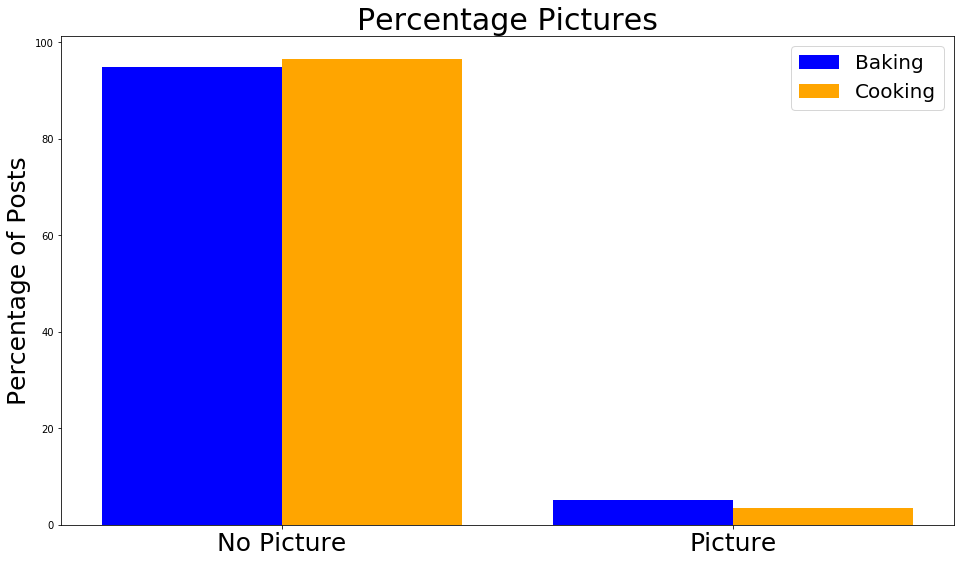

In [23]:
N = 2
ind = np.arange(N)  # the x locations for the groups
width = 0.4       # the width of the bars

#setting plot size
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)

#setting baking plot values
baking = baking_text['picture'].value_counts(normalize=True)*100
baking_plot = ax.bar(ind, baking, width, color='b')
#setting cooking plot values
cooking = cooking_text['picture'].value_counts(normalize=True)*100
cooking_plot = ax.bar(ind+width, cooking, width, color='orange')

#adding y label text and setting font size
ax.set_ylabel('Percentage of Posts',fontsize=25)
#setting X labels
ax.set_xticks(ind+width/2)
ax.set_xticklabels(('No Picture', 'Picture'),fontsize=25)
#setting legend
ax.legend( (baking_plot[0], cooking_plot[0]), ('Baking', 'Cooking') , fontsize=20)

#setting title
ax.set_title('Percentage Pictures',fontsize=30)

plt.savefig('./Pictures.png',dpi=90)

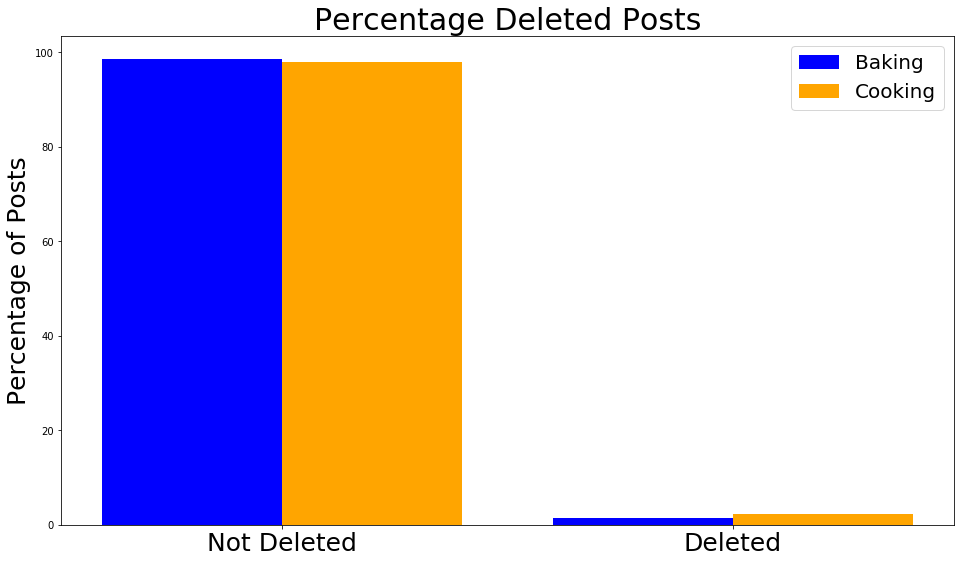

In [24]:
N = 2
ind = np.arange(N)  # the x locations for the groups
width = 0.4       # the width of the bars

#setting plot size
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)

#setting baking plot values
baking = baking_text['deleted'].value_counts(normalize=True)*100
baking_plot = ax.bar(ind, baking, width, color='b')
#setting cooking plot values
cooking = cooking_text['deleted'].value_counts(normalize=True)*100
cooking_plot = ax.bar(ind+width, cooking, width, color='orange')

#adding y label text and setting font size
ax.set_ylabel('Percentage of Posts',fontsize=25)
#setting X labels
ax.set_xticks(ind+width/2)
ax.set_xticklabels(('Not Deleted', 'Deleted'),fontsize=25)
#setting legend
ax.legend( (baking_plot[0], cooking_plot[0]), ('Baking', 'Cooking') , fontsize=20)

#setting title
ax.set_title('Percentage Deleted Posts',fontsize=30)

plt.savefig('./Deleted.png',dpi=90)

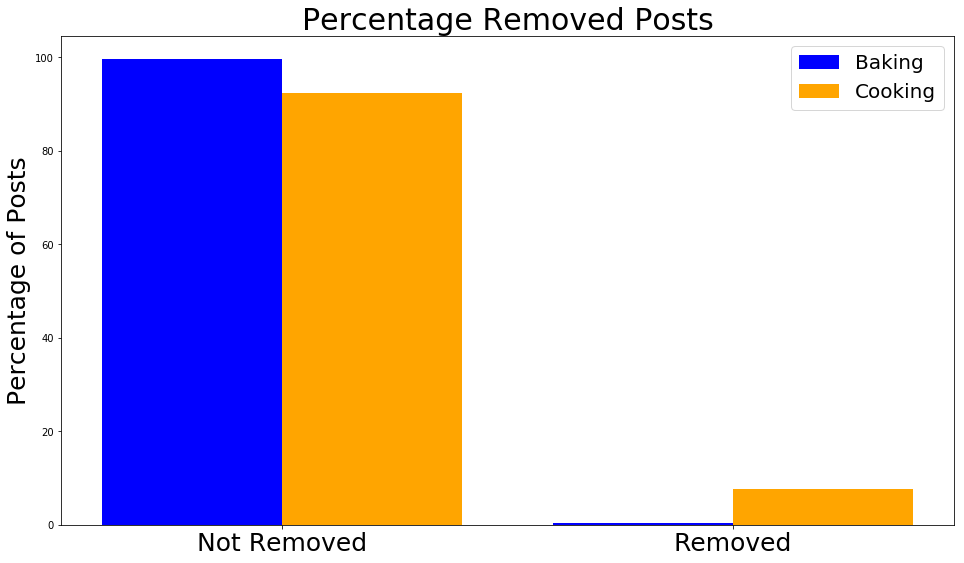

In [25]:
N = 2
ind = np.arange(N)  # the x locations for the groups
width = 0.4       # the width of the bars

#setting plot size
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)

#setting baking plot values
baking = baking_text['removed'].value_counts(normalize=True)*100
baking_plot = ax.bar(ind, baking, width, color='b')
#setting cooking plot values
cooking = cooking_text['removed'].value_counts(normalize=True)*100
cooking_plot = ax.bar(ind+width, cooking, width, color='orange')

#adding y label text and setting font size
ax.set_ylabel('Percentage of Posts',fontsize=25)
#setting X labels
ax.set_xticks(ind+width/2)
ax.set_xticklabels(('Not Removed', 'Removed'),fontsize=25)
#setting legend
ax.legend( (baking_plot[0], cooking_plot[0]), ('Baking', 'Cooking') , fontsize=20)

#setting title
ax.set_title('Percentage Removed Posts',fontsize=30)

plt.savefig('./Removed.png',dpi=90)

The Baking subreddit has more pictures than the Cooking subreddit. But the Cooking subreddit has more removed posts as well as more deleted posts. Baking has almost no removed posts and cooking has 7%. I would guess that may have to do with the size of the subreddits but it requires more investigation.

# Natural Language Processing

In [26]:
# Function inspired from Matt Brems 5.05-lesson-nlp_i 

def post_to_words(raw_post):
    # Function to convert a raw text post to a string of words
    # The input is a single string (title/self text/comment), and 
    # the output is a single string 
    #
#     # 1. Remove HTML
    review_text = BeautifulSoup(raw_post).get_text()
    #
    #removes all http link text
    no_pictures = re.sub('\((http.+)\)',' ',review_text)
    no_links = re.sub('(http.\S+)',' ',no_pictures)
    
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", no_links)
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()
    #
    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words('english'))
    # a
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]

    #
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(meaningful_words))

In [27]:
#convert baking text
baking_text['text'] = baking_text['text'].apply(lambda x: post_to_words(str(x)))
#remove empty text
baking_text = baking_text[baking_text['text'] != '']


In [28]:
baking_text.shape

(28747, 4)

In [29]:
baking_text.head()

text  picture  removed  \
0  anyone experience making brioche without stand...        0        0   
1  looking baking youtube channels run people chi...        0        0   
2                                     alternate view        1        0   
3  im planing making coffee chocolate glaze says ...        0        0   
4  made loads cakes bundt shapes attractive even ...        0        0   

   deleted  
0        0  
1        0  
2        0  
3        0  
4        0

In [30]:
#removing the posts that are just deleted and removed
baking_text = baking_text[(baking_text['text'] != 'deleted')&(baking_text['text'] != 'removed')]

In [31]:
baking_text.shape

(28224, 4)

In [32]:
cooking_text['text'] = cooking_text['text'].apply(lambda x: post_to_words(str(x)))

cooking_text = cooking_text[cooking_text['text'] != '']

In [33]:
cooking_text.shape

(73019, 4)

In [34]:
cooking_text = cooking_text[(cooking_text['deleted'] != 1)&(cooking_text['removed'] != 1)]

In [35]:
cooking_text.shape

(65858, 4)

In [36]:
#code from Sarah Scolnik
#instantiate the Lemmatizer
lemmatizer = nltk.WordNetLemmatizer()

#creating a fuction to lemmatize using noun.
def lemmatize_words_noun(text):
    #splitting the text into words
    words = text.split()
    #creating an empty string with a space to add to
    lemma_words = ''
    #looping though all the words in the text
    for word in words:
        # putting all the words back together and lemmatizing them using noun
        lemma_words += (lemmatizer.lemmatize(word,pos='n') + ' ')
    return lemma_words  

#creating a fuction to lemmatize using verb.
def lemmatize_words_verb(text):
    #splitting the text into words
    words = text.split()
    #creating an empty string with a space to add to
    lemma_words = ''
    #looping though all the words in the text
    for word in words:
        # putting all the words back together and lemmatizing them using verb
        lemma_words += (lemmatizer.lemmatize(word,pos='v') + ' ')
    return lemma_words  

In [37]:
#this list of stop words were created by reviewing the most common words that were found in both subreddits
mystopwords = text.ENGLISH_STOP_WORDS.union(['add','good','like','look','make','try','use','want','recipe',
                                           'think','thank','time','need','time','help','work','really','know','thing'])

In [38]:
#running noun lemmatizer 
cooking_text['text'] = cooking_text['text'].apply(lemmatize_words_noun)
baking_text['text'] = baking_text['text'].apply(lemmatize_words_noun)

In [39]:
#running verb lemmatizer. This was required to removed the cook and cooking as both are kept when you only do noun.
cooking_text['text'] = cooking_text['text'].apply(lemmatize_words_verb)
baking_text['text'] = baking_text['text'].apply(lemmatize_words_verb)

In [40]:
#Using count vectorizer to identify the most common words
vectorizer = CountVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = mystopwords,
                             max_features = 20) 

In [41]:
cookingvect = vectorizer.fit_transform(cooking_text['text'])

In [42]:
#creating a data frame to review the instances.
cookwords = pd.DataFrame(cookingvect.toarray(),columns=vectorizer.get_feature_names())
cookwords.mean().sort_values(ascending=False)*100

cook       30.058611
chicken    10.683592
sauce      10.373835
food        8.647393
pan         7.942847
oil         7.142640
eat         7.007501
meat        6.911841
fry         6.524644
way         6.515533
rice        6.445686
dish        6.398615
buy         6.000790
egg         5.900574
taste       5.803395
water       5.756324
oven        5.698624
salt        5.684959
idea        5.680403
cheese      5.244617
dtype: float64

In [43]:
#reviewing baking
vectorizer = CountVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = mystopwords,
                             max_features = 20) 
bakingvect = vectorizer.fit_transform(baking_text['text'])

In [44]:
bakewords = pd.DataFrame(bakingvect.toarray(),columns=vectorizer.get_feature_names())
bakewords.mean().sort_values(ascending=False)*100

cake         34.598214
bake         34.375000
chocolate    13.056264
sugar        11.206774
butter        9.977324
cooky         9.516723
flour         8.886054
bread         8.191610
cream         7.823129
pie           7.337727
cup           7.312925
love          7.110969
dough         6.933815
egg           6.912557
mix           6.728316
cupcake       6.498016
idea          6.381094
frost         5.998441
cookie        5.980726
oven          5.980726
dtype: float64

In [45]:
#I played around with count vectorizer and tfidf to see what created the best model I found that the best was 
#(1,4) ngrams. This is to check what were the top words with this.
vectorizerbak = TfidfVectorizer(stop_words=mystopwords,
                            ngram_range = (1,4),
                            max_features = 15)
featuresbak = vectorizerbak.fit_transform(baking_text['text'])

In [46]:
bakewords = pd.DataFrame(featuresbak.toarray(),columns=vectorizerbak.get_feature_names())
bakewords.mean().sort_values(ascending=False)*100

cake         14.931565
bake         14.315174
chocolate     5.564323
cooky         4.632482
love          4.258447
bread         4.085571
pie           3.673569
sugar         3.484594
butter        3.145238
cream         3.083878
flour         2.695615
dough         2.648519
mix           2.219289
egg           2.189933
cup           1.586343
dtype: float64

In [47]:
vectorizercoo = TfidfVectorizer(stop_words=mystopwords,
                            ngram_range = (1,4),
                            max_features = 15)
featurescoo = vectorizercoo.fit_transform(cooking_text['text'])
cookwords = pd.DataFrame(featurescoo.toarray(),columns=vectorizercoo.get_feature_names())
cookwords.mean().sort_values(ascending=False)*100

cook       13.364831
chicken     4.839531
food        4.601524
sauce       4.563306
eat         3.644702
way         3.587163
buy         3.586749
pan         3.420908
dish        3.278404
meat        3.255789
taste       2.930906
oil         2.769730
egg         2.706554
fry         2.670633
rice        2.617324
dtype: float64

Though we dont see the longer than 1 ngrams in the top 30 when I decrease the number of ngrams I found that the model preformed worse

### Cleaning Function

In [48]:
def cleaning(text):
    posttowords = text.apply(lambda x: post_to_words(str(x)))
    lemmatizer = nltk.WordNetLemmatizer()
    nounlems = posttowords.apply(lemmatize_words_noun)
    verblems = nounlems.apply(lemmatize_words_verb)
    return verblems

# Modeling

In [49]:
#adding a column that identifies the subreddit. Marking cooking as 1
cooking_model['subreddit'] = 1

In [50]:
#adding a column that identifies the subreddit. Marking cooking as 0
baking_model['subreddit'] = 0

In [51]:
cooking_model.shape

(73426, 5)

In [52]:
baking_model.shape

(28892, 5)

In [53]:
baking_model.head()

text  picture  removed  \
0  anyone experience making brioche without stand...        0        0   
1  looking baking youtube channels run people chi...        0        0   
2                                     alternate view        1        0   
3  im planing making coffee chocolate glaze says ...        0        0   
4  made loads cakes bundt shapes attractive even ...        0        0   

   deleted  subreddit  
0        0          0  
1        0          0  
2        0          0  
3        0          0  
4        0          0

In [54]:
#creating a text that is all of the text together.
merged_text = pd.concat([baking_model,cooking_model],axis=0)

In [55]:
merged_text.shape

(102318, 5)

In [56]:
merged_text['subreddit'].value_counts(normalize=True)

1    0.717625
0    0.282375
Name: subreddit, dtype: float64

#### The baseline is 71.7% for cooking

In [57]:
#defining X as the tfidfed vectorized words and instances and Y as the subreddit
X = merged_text['text']
y = merged_text['subreddit']

#train test spiltting for model evaluations.
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.50,random_state=42,stratify=y)

In [58]:
X_train_cl = cleaning(X_train)

In [59]:
X_test_cl = cleaning(X_test)

In [76]:
#vectorizing for modeling. I played around with the number of features and 20000 did the best with 1,4 ngrams
vectorizer = TfidfVectorizer(stop_words=stopwords,
                            ngram_range = (1,4),
                            max_features = 20000)
features = vectorizer.fit_transform(merged_text['text']).toarray()


In [72]:
features.shape

(94082, 20000)

In [74]:
# I used this logistic regression to check on the parameters of tfidf/counvectorizer since it ran fast
logreg = LogisticRegression(penalty='l1',C=1)

logreg.fit(X_train,y_train)
print(logreg.score(X_train,y_train))

0.8890967453923173


In [75]:
logreg.score(X_test,y_test)

0.8772347526625709

#### Logistic Regression

In [66]:
%%time
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=mystopwords,
                            ngram_range = (1,4),
                            max_features = 20000)),
    ('logreg', LogisticRegression())
])
params = {
    'logreg__penalty': ['l1','l2'],
    'logreg__C': [0.1, 1, 10]
    
}
grid = GridSearchCV(pipe,param_grid=params)
grid.fit(X_train_cl,y_train)

CPU times: user 3min 9s, sys: 6.45 s, total: 3min 16s
Wall time: 3min 12s


In [71]:
grid.best_estimator_.steps

[('tfidf',
  TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
          dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
          lowercase=True, max_df=1.0, max_features=20000, min_df=1,
          ngram_range=(1, 4), norm='l2', preprocessor=None, smooth_idf=True,
          stop_words=frozenset({'you', 'throughout', 'hundred', 'may', 'other', 'her', 'whither', 'itself', 'somewhere', 'below', 'being', 'five', 'me', 'its', 'himself', 'take', 'across', 'hers', 'our', 'fill', 'am', 'between', 'put', 'that', 'through', 'none', 'about', 'over', 'three', 'noone', 'interest', ...etail', 'towards', 'when', 'bill', 'against', 'please', 'nine', 'think', 'either', 'try', 'before'}),
          strip_accents=None, sublinear_tf=False,
          token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
          vocabulary=None)),
 ('logreg',
  LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_ite

In [73]:
print('train',grid.score(X_train_cl,y_train))
print('test',grid.score(X_test_cl,y_test))

train 0.9009362966437968
test 0.8812134717254051


#### Random Forest Classifier

The size of my data made it so that I was not able to run grid search with Random forest on my computer so I tested the different n_estimators indivually.

In [88]:
%%time
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=mystopwords,
                            ngram_range = (1,4),
                            max_features = 20000)),
    ('rf', RandomForestClassifier())
])
params = {
    'rf__n_estimators': [30,10]    
}
grid = GridSearchCV(pipe,param_grid=params)
grid.fit(X_train_cl,y_train)

CPU times: user 3min 26s, sys: 3.19 s, total: 3min 29s
Wall time: 3min 30s


In [89]:
print('train',grid.score(X_train_cl,y_train))
print('test',grid.score(X_test_cl,y_test))

train 0.9738853378682147
test 0.8724955530796146


In [90]:
grid.best_estimator_.steps[1]

('rf',
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False))

In [91]:
%%time
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=mystopwords,
                            ngram_range = (1,4),
                            max_features = 20000)),
    ('rf', RandomForestClassifier())
])
params = {
    'rf__n_estimators': [20,40,60,100]    
}
grid = GridSearchCV(pipe,param_grid=params)
grid.fit(X_train_cl,y_train)

print('train',grid.score(X_train_cl,y_train))
print('test',grid.score(X_test_cl,y_test))
print('best estimator',grid.best_estimator_.steps[1])

train 0.9745499325631853
test 0.8746066185812857
best estimator ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))
CPU times: user 13min 58s, sys: 7.15 s, total: 14min 5s
Wall time: 14min 53s


### Naive Bayes

In [92]:
%%time
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=mystopwords,
                            ngram_range = (1,4),
                            max_features = 20000)),
    ('nb', MultinomialNB())
])

pipe.fit(X_train_cl,y_train)

print('train',pipe.score(X_train_cl,y_train))
print('test',pipe.score(X_test_cl,y_test))



train 0.8903614222326472
test 0.8714400203287789
CPU times: user 15.9 s, sys: 645 ms, total: 16.6 s
Wall time: 16.7 s


In [87]:
print('train',nb.score(X_train,y_train))
print('test',nb.score(X_test,y_test))

train 0.8870559724495652
test 0.8698794668480687


In [93]:
%%time
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=mystopwords,
                            ngram_range = (1,4),
                            max_features = 20000)),
    ('SVC', SVC())
])

pipe.fit(X_train_cl,y_train)

print('train',pipe.score(X_train_cl,y_train))
print('test',pipe.score(X_test_cl,y_test))

train 0.7176254422486757
test 0.7176254422486757
CPU times: user 10min 3s, sys: 6.07 s, total: 10min 9s
Wall time: 13min 33s


In [96]:
%%time
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=mystopwords,
                            ngram_range = (1,4),
                            max_features = 20000)),
    ('svc', SVC())
])
params = {
    'svc__C': [0.01, 0.1, 10]
}
grid = GridSearchCV(pipe,param_grid=params)
grid.fit(X_train_cl,y_train)

print('train',grid.score(X_train_cl,y_train))
print('test',grid.score(X_test_cl,y_test))
print('best estimator',grid.best_estimator_.steps[1])

train 0.7176254422486757
test 0.7176254422486757
best estimator ('svc', SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))
CPU times: user 42min 49s, sys: 23.3 s, total: 43min 12s
Wall time: 43min 46s


In [98]:
%%time
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=mystopwords,
                            ngram_range = (1,4),
                            max_features = 20000)),
    ('svc', SVC())
])
params = {
    'svc__gamma': [0.01, 0.1, 1]
}
grid = GridSearchCV(pipe,param_grid=params)
grid.fit(X_train_cl,y_train)

print('train',grid.score(X_train_cl,y_train))
print('test',grid.score(X_test_cl,y_test))
print('best estimator',grid.best_estimator_.steps[1])

train 0.9467542367911804
test 0.8819758009343419
best estimator ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))
CPU times: user 51min 1s, sys: 27.9 s, total: 51min 29s
Wall time: 52min 53s


In [63]:
%%time
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=mystopwords,
                            ngram_range = (1,4),
                            max_features = 20000)),
    ('svc', SVC(C=0.01,gamma=1))
])
pipe.fit(X_train_cl,y_train)

print('train',pipe.score(X_train_cl,y_train))
print('test',pipe.score(X_test_cl,y_test))

train 0.7197169608475537
test 0.7191891944721359
CPU times: user 10min 54s, sys: 4.93 s, total: 10min 59s
Wall time: 11min 6s


In [60]:
%%time
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=mystopwords,
                            ngram_range = (1,4),
                            max_features = 20000)),
    ('svc', SVC(C=1,gamma=10))
])
pipe.fit(X_train_cl,y_train)

print('train',pipe.score(X_train_cl,y_train))
print('test',pipe.score(X_test_cl,y_test))

train 0.973904884771008
test 0.7313669149123322
CPU times: user 29min 43s, sys: 7.57 s, total: 29min 51s
Wall time: 30min 2s
